<a href="https://colab.research.google.com/github/jecampagne/cours_mallat_cdf/blob/main/scattering1D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install -q kymatio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.6/87.6 KB 1.3 MB/s eta 0:00:00


In [2]:
! pip install -q ssqueezepy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.0/125.0 KB 3.4 MB/s eta 0:00:00


In [145]:
import numpy as np
import matplotlib.pyplot as plt

from ssqueezepy import cwt
from ssqueezepy.experimental import scale_to_freq
from ssqueezepy.visuals import plot, imshow

# Scattering coefficients to analyse 1D signals

In [5]:
# 1 single note with a decreasing envelop  
def sigAtt(t, fb, fm):
  return  np.sin(2. *np.pi *fb *t) * (1. + np.exp(-t *fm))/2

# Tremolo modulation of a single note
def sigTremolo(t, fb, fm):
  return np.sin(2. *np.pi *fb *t) * np.cos(2.  *np.pi *fm *t)

# Vibrato modulation of a single note
def sigVibrato(t, fb, fm):
  return np.sin(2.  *np.pi  *fb *(1 + 0.0003 *np.cos(2. *np.pi *fm *t)) *t)

# to separate the different music sequences
def  smoothPi(t):
  return  -1 + (1/(1 + np.exp(-20 *(t + 1/2))) + 1/(1 + np.exp(-20*(-t + 1/2))))

def wind(t, tMin, tMax): 
 return smoothPi(1/(tMax - tMin) * (t - (tMin + tMax)/2.) + 0.001)

In [85]:
def sigTot(t):
  return sigAtt(t, 2000., 2.) * wind(t, 0., 1.) + \
    sigTremolo(t + 0.05, 2000., 5.) * wind(t, 1.1, 2.) + \
    sigVibrato(t, 2000., 10.) * wind(t, 2.1, 3.)

#def sigTot(t):
#  return sigAtt(t, 2000., 0.)  #verif the frequency y-ticks

In [86]:
Nsamples = 2**14 # need this nber of samples for Wavelet
t = np.linspace(0., 3., Nsamples,True)

In [144]:
#plot the signal is not so help full
#plt.figure(figsize=(10,5))
#plt.plot(t,sigTot(t))

# First stage 

Wavelet decomposition of the signal using $\psi_\lambda$ ($\psi$ default Morlet complex wavelet) to get $|x \ast \psi_\lambda|$ scalograme

In [89]:
x = sigTot(t)
Wx, scales = cwt(x, 'morlet')
freqs = scale_to_freq(scales, 'morlet', Nsamples, fs=Nsamples/3)

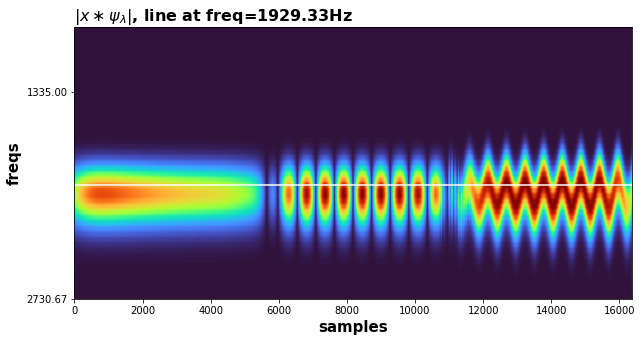

In [142]:
fig,ax = plt.subplots(1,1, figsize=(10,5))
index = 21
stest = scales[index]

imshow(Wx, yticks=freqs, abs=1, ax=ax, show=0,
       title=fr"$|x\ast \psi_\lambda|$, line at freq={freqs[index]:.2f}Hz",
       ylabel="freqs", xlabel="samples")
ax.set_ylim([0,50])
ax.axhline(y=index,c="white")


# Second stage

Extract a frequency slice corresponding to $|x \ast \psi_{\lambda_0}|$  and perform new wavelet decomposition to this signal

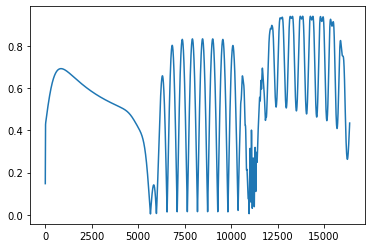

In [125]:
plt.plot(np.abs(Wx[index]))

In [126]:
xBis = np.abs(Wx[index])
Wx_bis, _ = cwt(xBis, 'morlet')
maxW = np.max(np.abs(Wx_bis))

(200.0, 250.0)

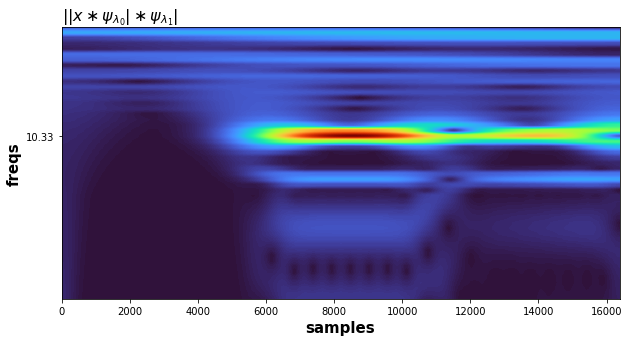

In [147]:
fig,ax = plt.subplots(1,1, figsize=(10,5))
imshow(Wx_bis, yticks=freqs, abs=1, ax=ax, show=0,
       title=r"$||x\ast \psi_{\lambda_0}|\ast \psi_{\lambda_1}|$",
       ylabel="freqs", xlabel="samples")
ax.set_ylim([200,250])

# More advanced decomposition (Kyamato)

- [The doc](https://www.kymat.io/codereference.html)

- A Morlet wavelet with Q: the number of wavelet per octave

- The scattering coefficients include the low pass filtering at each stage 

In [190]:
from kymatio.numpy import Scattering1D
from kymatio.scattering1d.filter_bank import scattering_filter_factory

In [191]:
J = 6         # the maximum scale 2^6 = 64
Q = (16, 1)   # 16 wavelets per octave at first stage and 1 per octave at second stage
T = Nsamples

Examine the filter in the frequency domain et one in the time domain.

In [192]:
phi_f, psi1_f, psi2_f = scattering_filter_factory(T, J, Q, T)

Text(0.5, 1.0, 'Frequency response of first-order filters (Q = (16, 1))')

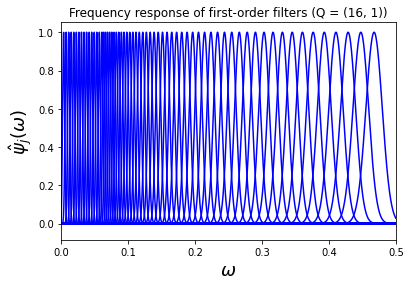

In [204]:
plt.figure()
plt.plot(np.arange(T)/T, phi_f['levels'][0], 'r')

for psi_f in psi1_f:
    plt.plot(np.arange(T)/T, psi_f['levels'][0], 'b')

plt.xlim(0, 0.5)

plt.xlabel(r'$\omega$', fontsize=18)
plt.ylabel(r'$\hat\psi_j(\omega)$', fontsize=18)
plt.title('Frequency response of first-order filters (Q = {})'.format(Q),
          fontsize=12)
#plt.xscale("log")

Text(0.5, 1.0, 'Frequency response of second-order filters (Q = 1)')

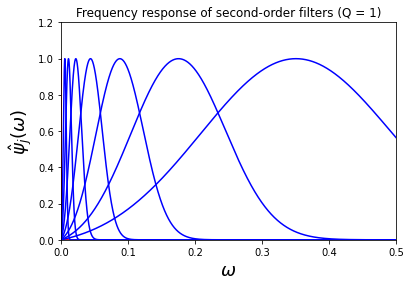

In [203]:
plt.figure()
#plt.rcParams.update({"text.usetex": True})
plt.plot(np.arange(T)/T, phi_f['levels'][0], 'r')
for psi_f in psi2_f:
    plt.plot(np.arange(T)/T, psi_f['levels'][0], 'b')
plt.xlim(0, 0.5)
plt.ylim(0, 1.2)
plt.xlabel(r'$\omega$', fontsize=18)
plt.ylabel(r'$\hat\psi_j(\omega)$', fontsize=18)
plt.title('Frequency response of second-order filters (Q = 1)', fontsize=12)


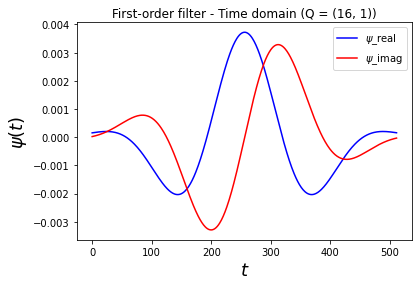

In [205]:
plt.figure()
#plt.rcParams.update({"text.usetex": True})

psi_time = np.fft.ifft(psi1_f[-1]['levels'][0])
psi_real = np.real(psi_time)
psi_imag = np.imag(psi_time)
plt.plot(np.concatenate((psi_real[-2**8:],psi_real[:2**8])),'b')
plt.plot(np.concatenate((psi_imag[-2**8:],psi_imag[:2**8])),'r')


plt.xlabel(r'$t$', fontsize=18)
plt.ylabel(r'$\psi(t)$', fontsize=18)
plt.title('First-order filter - Time domain (Q = {})'.format(Q), fontsize=12)
plt.legend(["$\psi$_real","$\psi$_imag"])

plt.show()

Proceed to scattering transform

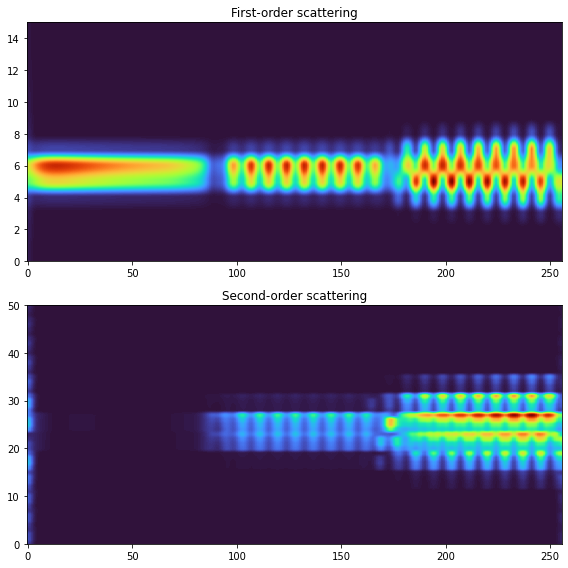

In [206]:

scattering = Scattering1D(J, Nsamples, Q)

meta = scattering.meta()
order0 = np.where(meta['order'] == 0)
order1 = np.where(meta['order'] == 1)
order2 = np.where(meta['order'] == 2)

Sx = scattering(x)

fig, axs = plt.subplots(2,1,figsize=(8, 8))
axs[0].imshow(Sx[order1], aspect='auto', cmap="turbo")
axs[0].set_title('First-order scattering')
axs[0].set_ylim([0,15])
axs[1].imshow(Sx[order2], aspect='auto', cmap="turbo")
axs[1].set_title('Second-order scattering')
axs[1].set_ylim([0,50])
plt.tight_layout()
plt.show()